## Import Relevant packages

In [75]:
import pandas as pd
import numpy as np
import io

# For Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from collections import Counter

# For Data Preparation
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stop_words = ENGLISH_STOP_WORDS.union(['&'])
from sklearn.tree import plot_tree

# For Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold

# For Evaluation of Results
from sklearn.metrics import f1_score
from sklearn import metrics


## Importing of Dataset

In [44]:
#Importing files from local to the notebook
from google.colab import files
uploaded = files.upload()

Saving FakeNewsNet.csv to FakeNewsNet (1).csv


In [45]:
df = pd.read_csv(io.BytesIO(uploaded['FakeNewsNet.csv']))
##df = pd.read_csv('FakeNewsNet.csv')
df.shape

(23196, 5)

In [46]:
df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          23196 non-null  object
 1   news_url       22866 non-null  object
 2   source_domain  22866 non-null  object
 3   tweet_num      23196 non-null  int64 
 4   real           23196 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 906.2+ KB


In [48]:
df = df.drop(['news_url', 'source_domain'], axis=1)
df.rename(columns={'real':'Fake', 'title':'Message'}, inplace = True)
df.head()

,Message,tweet_num,Fake
0,Kandi Burruss Explodes Over Rape Accusation on...,42,1
1,People's Choice Awards 2018: The best red carp...,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,63,1
3,Colombian singer Maluma sparks rumours of inap...,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,38,1


In [49]:
df.shape 

(23196, 3)

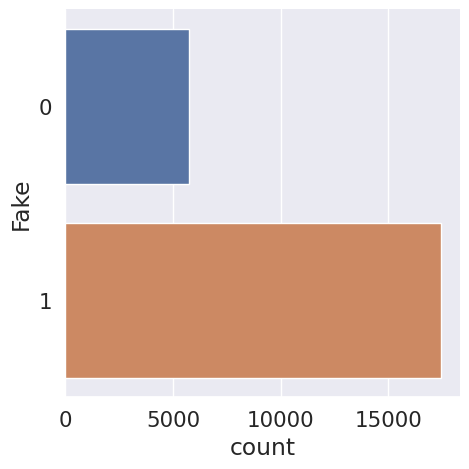

In [50]:
sns.catplot(y='Fake', data=df, kind='count')

In [51]:
countY, countX = df.Fake.value_counts()
print("The ratio of real to fake is %.2f: 1" % (countY/countX))

The ratio of real to fake is 3.03: 1


## Data Cleaning

#### Removal of duplicates in Messages

In [52]:
df.duplicated(subset=['Message']).value_counts()

False    21724
True      1472
dtype: int64

In [53]:
df = df.drop_duplicates(subset=['Message'], keep = 'last')
df.reset_index(drop=True, inplace=True)

print(df.shape)
print(df["Fake"].value_counts())

(21724, 3)
1    16459
0     5265
Name: Fake, dtype: int64


In [54]:
df.describe()

,tweet_num,Fake
count,21724.000000,21724.000000
mean,83.663460,0.757641
std,461.072386,0.428520
min,0.000000,0.000000
25%,11.000000,1.000000
50%,37.000000,1.000000
75%,65.000000,1.000000
max,29060.000000,1.000000


# Exploratory Data Analysis and Visualisation



[link text](https://)#### Comparing word count of fake and real messages

In [55]:
fake_messages = df[df['Fake'] == 1]['Message'].str.lower()
real_messages = df[df['Fake'] == 0]['Message'].str.lower()

fake_lengths = [len(x) for x in fake_messages]
real_lengths = [len(x) for x in real_messages]

fake = pd.DataFrame({'Fake':fake_lengths})
print(fake.describe())
real = pd.DataFrame({'Real':real_lengths})
print(real.describe())

               Fake
count  16459.000000
mean      68.910444
std       22.507244
min       10.000000
25%       55.000000
50%       68.000000
75%       84.000000
max      340.000000
              Real
count  5265.000000
mean     69.308832
std      23.346528
min      10.000000
25%      55.000000
50%      69.000000
75%      84.000000
max     200.000000


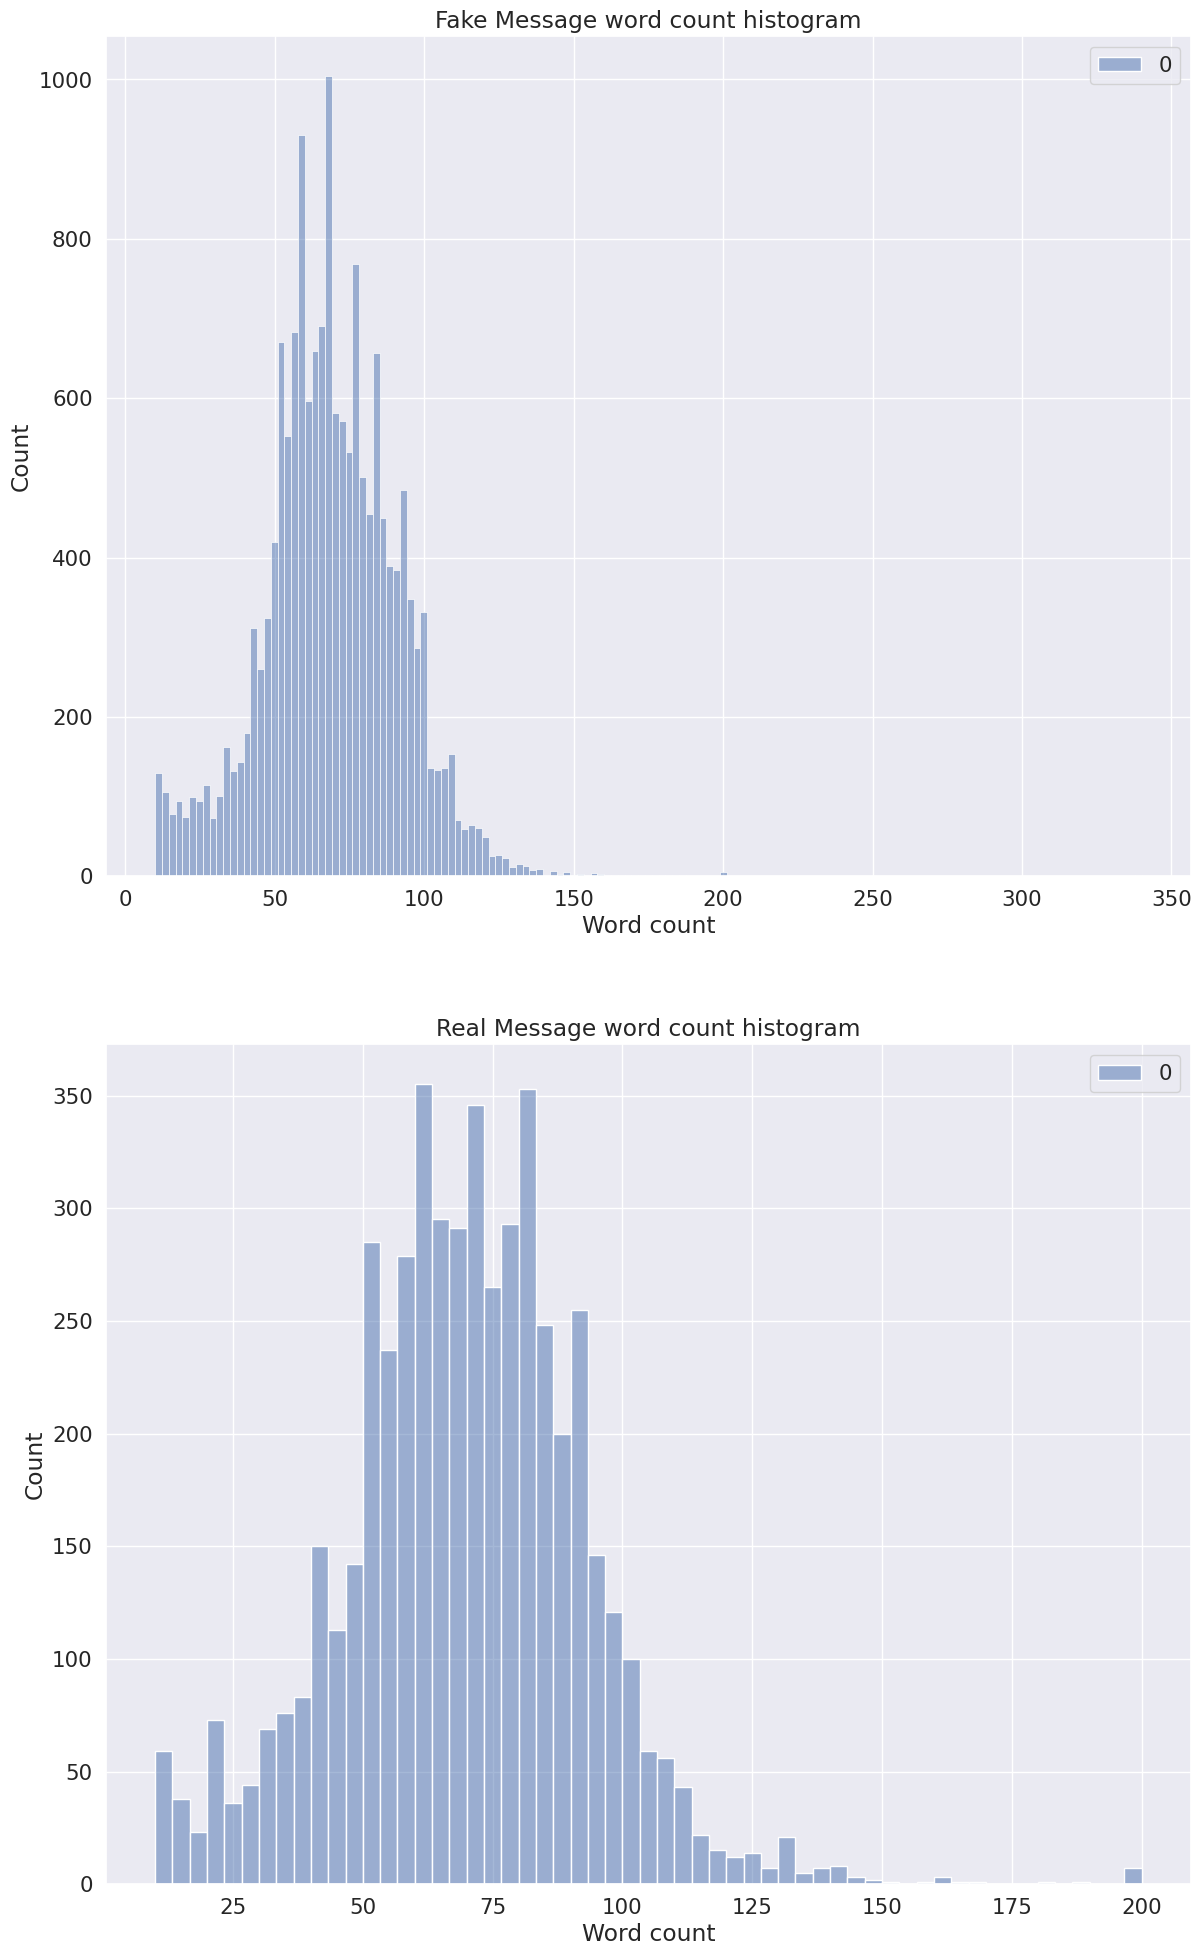

In [56]:
f, axes = plt.subplots(2, 1, figsize=(14, 24))

sns.histplot(data=[fake_lengths], ax=axes[0]).set(
    title="Fake Message word count histogram", 
    xlabel='Word count') 
sns.histplot(data=[real_lengths], ax=axes[1]).set(
    title="Real Message word count histogram", 
    xlabel='Word count') 

plt.show()

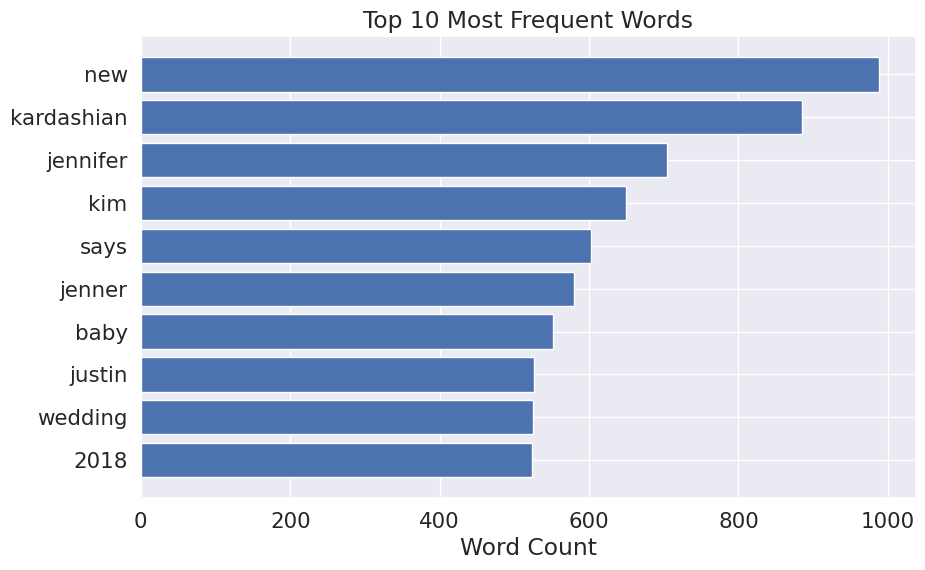

In [95]:
words = [word for message in ' '.join(df['Message']).split() for word in message.lower().split() if word not in stop_words]
words_counts = Counter(words).most_common(10)

fig, ax = plt.subplots(figsize=(10, 6))
y_pos = range(len(words_counts))
ax.barh(y_pos, [count for word, count in words_counts])
ax.set_yticks(y_pos)
ax.set_yticklabels([word for word, count in words_counts])
ax.invert_yaxis()
ax.set_xlabel('Word Count')
ax.set_title('Top 10 Most Frequent Words')
plt.show()

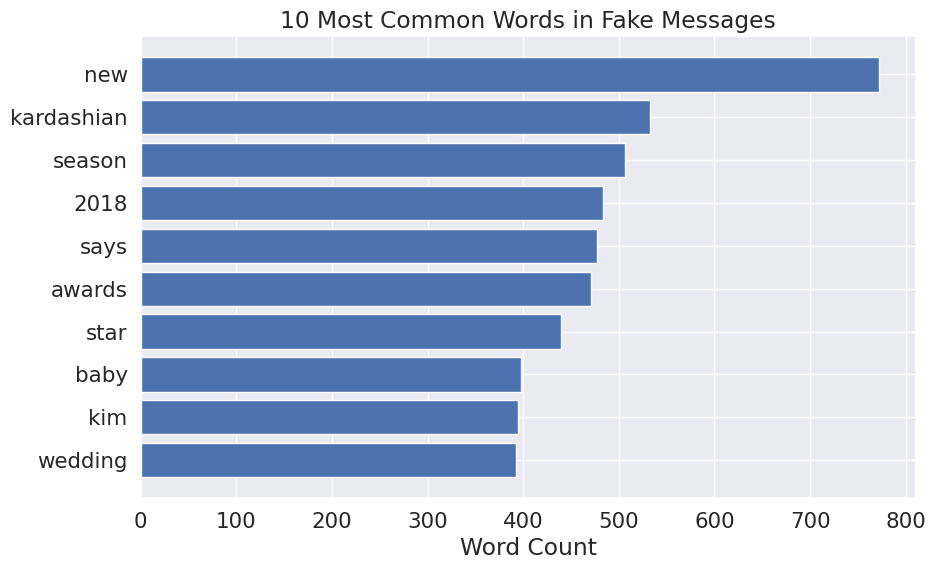

In [96]:
fake_messages = df[df['Fake'] == 1]['Message']
fake_words = [word for message in fake_messages for word in message.lower().split() if word not in stop_words]
fake_words_counts = Counter(fake_words).most_common(10)

fig, ax = plt.subplots(figsize=(10, 6))
y_pos = range(len(fake_words_counts))
ax.barh(y_pos, [count for word, count in fake_words_counts])
ax.set_yticks(y_pos)
ax.set_yticklabels([word for word, count in fake_words_counts])
ax.invert_yaxis()  
ax.set_xlabel('Word Count')
ax.set_title('10 Most Common Words in Fake Messages')
plt.show()

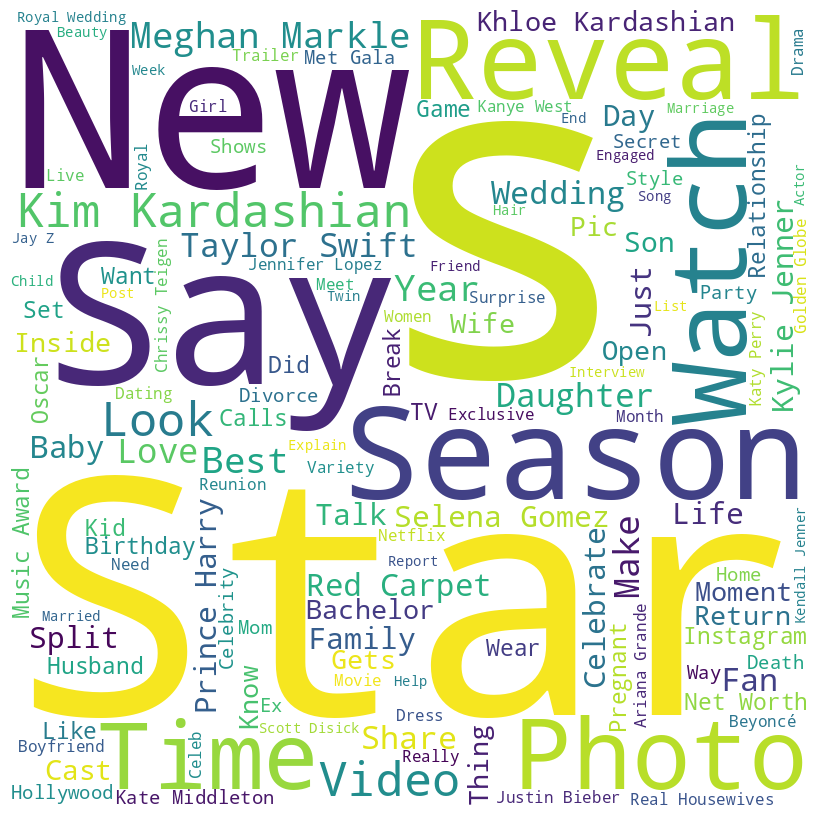

In [97]:
fake_text = ' '.join(fake_messages)

wordcloud = WordCloud(width=800, height=800, background_color='white',stopwords=stop_words,min_font_size=10).generate(fake_text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

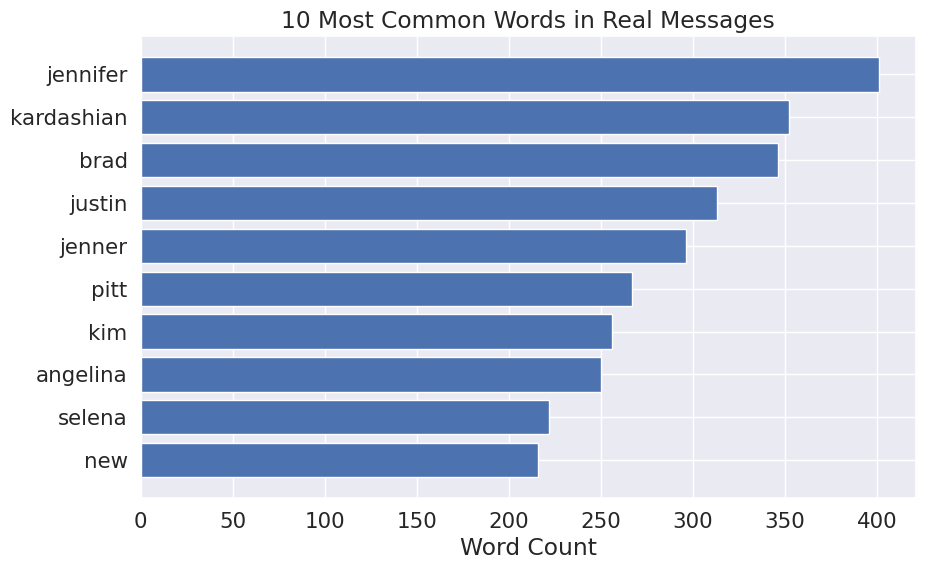

In [98]:
real_messages = df[df['Fake'] == 0]['Message']
real_words = [word for message in real_messages for word in message.lower().split() if word not in stop_words]
real_words_counts = Counter(real_words).most_common(10)

fig, ax = plt.subplots(figsize=(10, 6))
y_pos = range(len(real_words_counts))
ax.barh(y_pos, [count for word, count in real_words_counts])
ax.set_yticks(y_pos)
ax.set_yticklabels([word for word, count in real_words_counts])
ax.invert_yaxis()  
ax.set_xlabel('Word Count')
ax.set_title('10 Most Common Words in Real Messages')
plt.show()

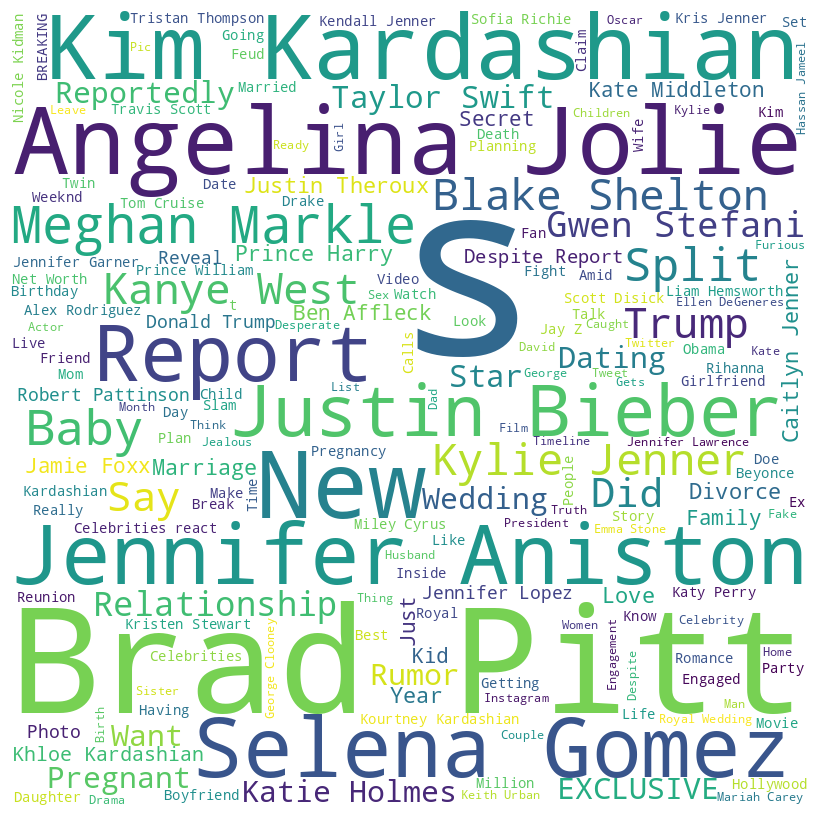

In [99]:
real_text = ' '.join(real_messages)

wordcloud = WordCloud(width=800, height=800, stopwords=stop_words,background_color='white', min_font_size=10).generate(real_text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Machine Learning

In [100]:
df_x = df.Message
df_y = df.Fake

In [101]:
cv = TfidfVectorizer(min_df = 1, stop_words='english')

In [102]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.2, random_state = 42)
test_length = len(x_test)

In [103]:
x_traincv = cv.fit_transform(x_train)
x_testcv = cv.transform(x_test)

## Naive Bayes

In [104]:
mnb_nb = MultinomialNB()
a_nb = x_traincv.toarray()
y_train = y_train.astype(int)
y_test = y_test.astype(int)
mnb_nb.fit(x_traincv, y_train)

MultinomialNB()

In [105]:
y_pred_nb = mnb_nb.predict(x_testcv)
actual_nb = np.array(y_test)

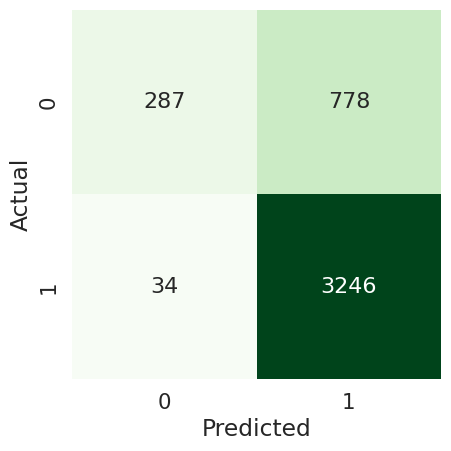

In [107]:
cm = confusion_matrix(actual_nb, y_pred_nb)
sns.set(font_scale=1.4) 
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', cbar=False, annot_kws={"size": 16}, square=True)

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [111]:
acc_nb = (cm[0][0] + cm[1][1]) / (cm[1][0] + cm[0][1] + cm[0][0] + cm[1][1])
print("True Positive Rate (TPR): ",cm[1][1]/(cm[1][1] + cm[1][0]))
print("True Negative Rate (TPR): ",cm[0][0]/(cm[0][0] + cm[0][1]))
print("False Positive Rate (FPR): ",cm[0][1]/(cm[0][0] + cm[0][1]))
print("False Negative Rate (FNR): ",cm[1][0]/(cm[1][1] + cm[1][0]))
print("Accuracy: ", acc_nb)
print("F1 Score: ", f1_score(actual_nb, y_pred_nb))

True Positive Rate (TPR):  0.9896341463414634
True Negative Rate (TPR):  0.26948356807511736
False Positive Rate (FPR):  0.7305164319248826
False Negative Rate (FNR):  0.010365853658536586
Accuracy:  0.8131185270425777
F1 Score:  0.888828039430449


## Random Forest Classifier

In [ ]:
classifier_rfc = RandomForestClassifier()
classifier_rfc.fit(x_traincv, y_train)
y_pred_rfc = classifier_rfc.predict(x_testcv)

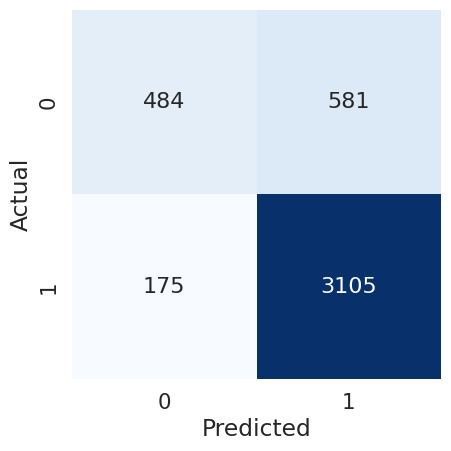

In [ ]:
cm = confusion_matrix(y_test, y_pred_rfc)
sns.set(font_scale=1.4) 
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={"size": 16}, square=True)

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

#### Calculate Accuracies

In [112]:
acc_rfc = (cm[0][0] + cm[1][1]) / (cm[1][0] + cm[0][1] + cm[0][0] + cm[1][1])
print("True Positive Rate (TPR): ",cm[1][1]/(cm[1][1] + cm[1][0]))
print("True Negative Rate (TPR): ",cm[0][0]/(cm[0][0] + cm[0][1]))
print("False Positive Rate (FPR): ",cm[0][1]/(cm[0][0] + cm[0][1]))
print("False Negative Rate (FNR): ",cm[1][0]/(cm[1][1] + cm[1][0]))
print("Accuracy: ", acc_rfc)
print("F1 Score: ", f1_score(y_test, y_pred_rfc))

True Positive Rate (TPR):  0.9896341463414634
True Negative Rate (TPR):  0.26948356807511736
False Positive Rate (FPR):  0.7305164319248826
False Negative Rate (FNR):  0.010365853658536586
Accuracy:  0.8131185270425777
F1 Score:  0.8906697195191756


Logistic regression turns out to be the worst of all of the 2 models we have tried. It has the highest false positive rate and false negative rate.

## K-Fold Cross-Validation


In [113]:
kf = KFold(n_splits= 5, shuffle=True, random_state=42)

nb_scores = []
rfc_scores = []

for train_index, test_index in kf.split(df_x):
    x_train_kfold, x_test_kfold = df_x.iloc[train_index], df_x.iloc[test_index]
    y_train_kfold, y_test_kfold = df_y.iloc[train_index], df_y.iloc[test_index]
    
    y_train_kfold = y_train_kfold.astype(int)
    y_test_kfold = y_test_kfold.astype(int)
    y_test_kfold = np.array(y_test_kfold)

    x_traincv_kfold = cv.fit_transform(x_train_kfold)
    x_testcv_kfold = cv.transform(x_test_kfold)

    mnb_nb_kfold = MultinomialNB()
    mnb_nb_kfold.fit(x_traincv_kfold, y_train_kfold)
    y_pred_nb_kfold = mnb_nb_kfold.predict(x_testcv_kfold)
    nb_scores.append(accuracy_score(y_test_kfold, y_pred_nb_kfold))
    
    rfc_kfold = RandomForestClassifier()
    rfc_kfold.fit(x_traincv_kfold, y_train_kfold)
    y_pred_rfc_kfold = rfc_kfold.predict(x_testcv_kfold)
    rfc_scores.append(accuracy_score(y_test_kfold, y_pred_rfc_kfold))
    
    

In [114]:
def average(item):
    return float(sum(item) / len(item))

In [115]:
k_fold_data = {'Model':['Naive Bayes', 'Random Forest Classifier'],'Accuracy':[acc_nb, acc_rfc], 'K-Fold Accuracy':[average(nb_scores), average(rfc_scores)]}
k_fold_df = pd.DataFrame.from_dict(k_fold_data)
k_fold_df

,Model,Accuracy,K-Fold Accuracy
0,Naive Bayes,0.813119,0.816286
1,Random Forest Classifier,0.813119,0.828945


### K-Fold Accuracies

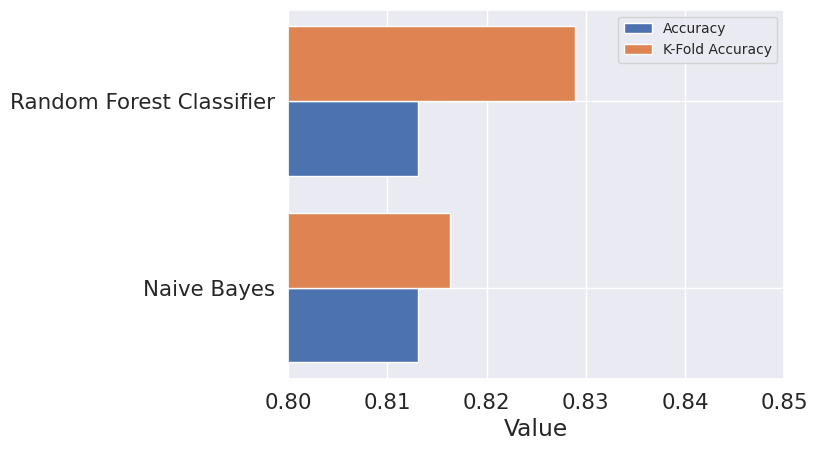

In [116]:
fig, ax = plt.subplots()

bar_width = 0.4

bar_pos1 = [0, 1]
bar_pos2 = [x + bar_width for x in bar_pos1]

ax.barh(bar_pos1, k_fold_df['Accuracy'], height=bar_width, label='Accuracy')

ax.barh(bar_pos2, k_fold_df['K-Fold Accuracy'], height=bar_width, label='K-Fold Accuracy')

ax.set_yticks([x + bar_width / 2 for x in bar_pos1])
ax.set_yticklabels(k_fold_df['Model'])

ax.set_xlabel('Value')
ax.set_xlim([0.8, 0.85])

ax.legend(fontsize = 10)

plt.show()

## Analysis of Findings


### ROC Curve

<Figure size 640x480 with 0 Axes>

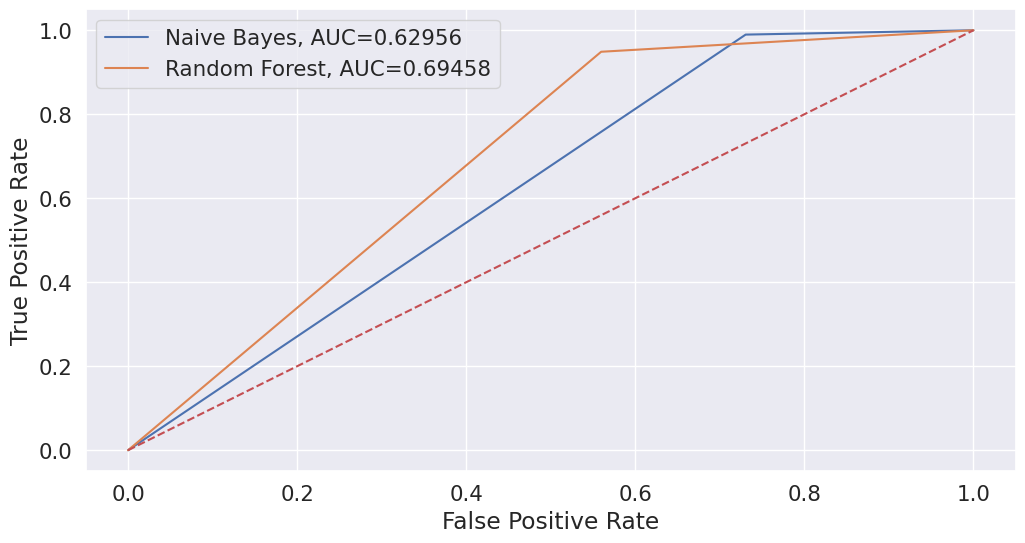

In [117]:
plt.figure(0).clf()
f = plt.figure(figsize=(12, 6))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_nb)
auc = round(metrics.roc_auc_score(y_test, y_pred_nb), 5)
plt.plot(fpr,tpr,label="Naive Bayes, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_rfc)
auc = round(metrics.roc_auc_score(y_test, y_pred_rfc), 5)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

plt.plot([0, 1], [0, 1],'r--')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend()
plt.show()

### Scatter Plot

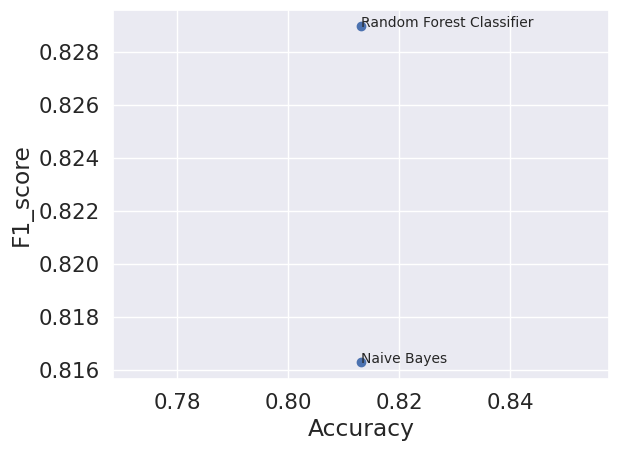

In [118]:
plt.scatter(k_fold_df.Accuracy,k_fold_df["K-Fold Accuracy"])
plt.ylabel("F1_score")
plt.xlabel("Accuracy")
for i, row in k_fold_df.iterrows():
    plt.annotate(row['Model'], (row['Accuracy'], row['K-Fold Accuracy']),fontsize=10)

plt.show()